In [1]:
import numpy as np
import jax.numpy as jnp
import jax


from mpl_toolkits.axes_grid1 import ImageGrid
import matplotlib.pyplot as plt
import nmu
from circuitmap import NeuralDemixer

import sys
sys.path.append('../')
import grid_utils as util
import subtract_utils as subtract_utils
%reload_ext subtract_utils
import os
import glob

plt.rcParams['figure.dpi'] = 300


In [8]:
data_path = 'data/masato/B6WT_AAV_hsyn_chrome2f_gcamp8/preprocessed/'
files = glob.glob(data_path + '*.npz')
print(files)

['data/masato/B6WT_AAV_hsyn_chrome2f_gcamp8/preprocessed/220308_B6_Chrome2fGC8_030822_Cell2_opsPositive_A_grid.npz', 'data/masato/B6WT_AAV_hsyn_chrome2f_gcamp8/preprocessed/220314_WT_Chrome2fGC8_IV_031422_MultispotGrid_Cell3_opsPositive_A_planes.npz', 'data/masato/B6WT_AAV_hsyn_chrome2f_gcamp8/preprocessed/220308_B6_Chrome2fGC8_030822_Cell1_OpsPositive_A_planes.npz', 'data/masato/B6WT_AAV_hsyn_chrome2f_gcamp8/preprocessed/220308_B6_Chrome2fGC8_030822_Cell2_opsPositive_A_planes.npz', 'data/masato/B6WT_AAV_hsyn_chrome2f_gcamp8/preprocessed/220314_WT_Chrome2fGC8_IV_031422_MultispotGrid_Cell3_opsPositive_A_grid.npz', 'data/masato/B6WT_AAV_hsyn_chrome2f_gcamp8/preprocessed/220314_WT_Chrome2fGC8_IV_031422_MultispotGrid_Cell1_opsPositive_A_planes.npz']


In [9]:

file_idx = 0
full_path = files[file_idx]
demixer_checkpoint = "/Users/Bantin/Documents/Columbia/Projects/2p-opto/circuit_mapping/demixers/nwd_ee_ChroME1.ckpt"
dat = np.load(full_path, allow_pickle='True')

pscs, I, L = dat['psc'], dat['I'], dat['L']



num_powers = len(np.unique(I))
if 'grid' in dset_name: #multispot
    I = np.ravel(I.T)
    L = np.tile(L, (num_powers,1,1))
elif 'planes' in dset_name: #singlespot
    L = L[:,None,:]
else:
    raise ValueError("Unrecognized filename. Aborting.")

# Form stim matrix and map from locations to indices
stim_mat, loc_map = util.make_stim_matrix(I, L)

In [10]:

results = subtract_utils.run_subtraction_pipeline(pscs, I, L, stim_mat,
    demixer_checkpoint, separate_by_power=False, rank=1)
dset_name = os.path.basename(full_path).split('.')[0]

/Users/bantin/Documents/Columbia/Projects/2p-opto/mbcs_grids/subtractr.py:52: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  V_post = np.linalg.lstsq(U_stim, pscs_truncated)[0]


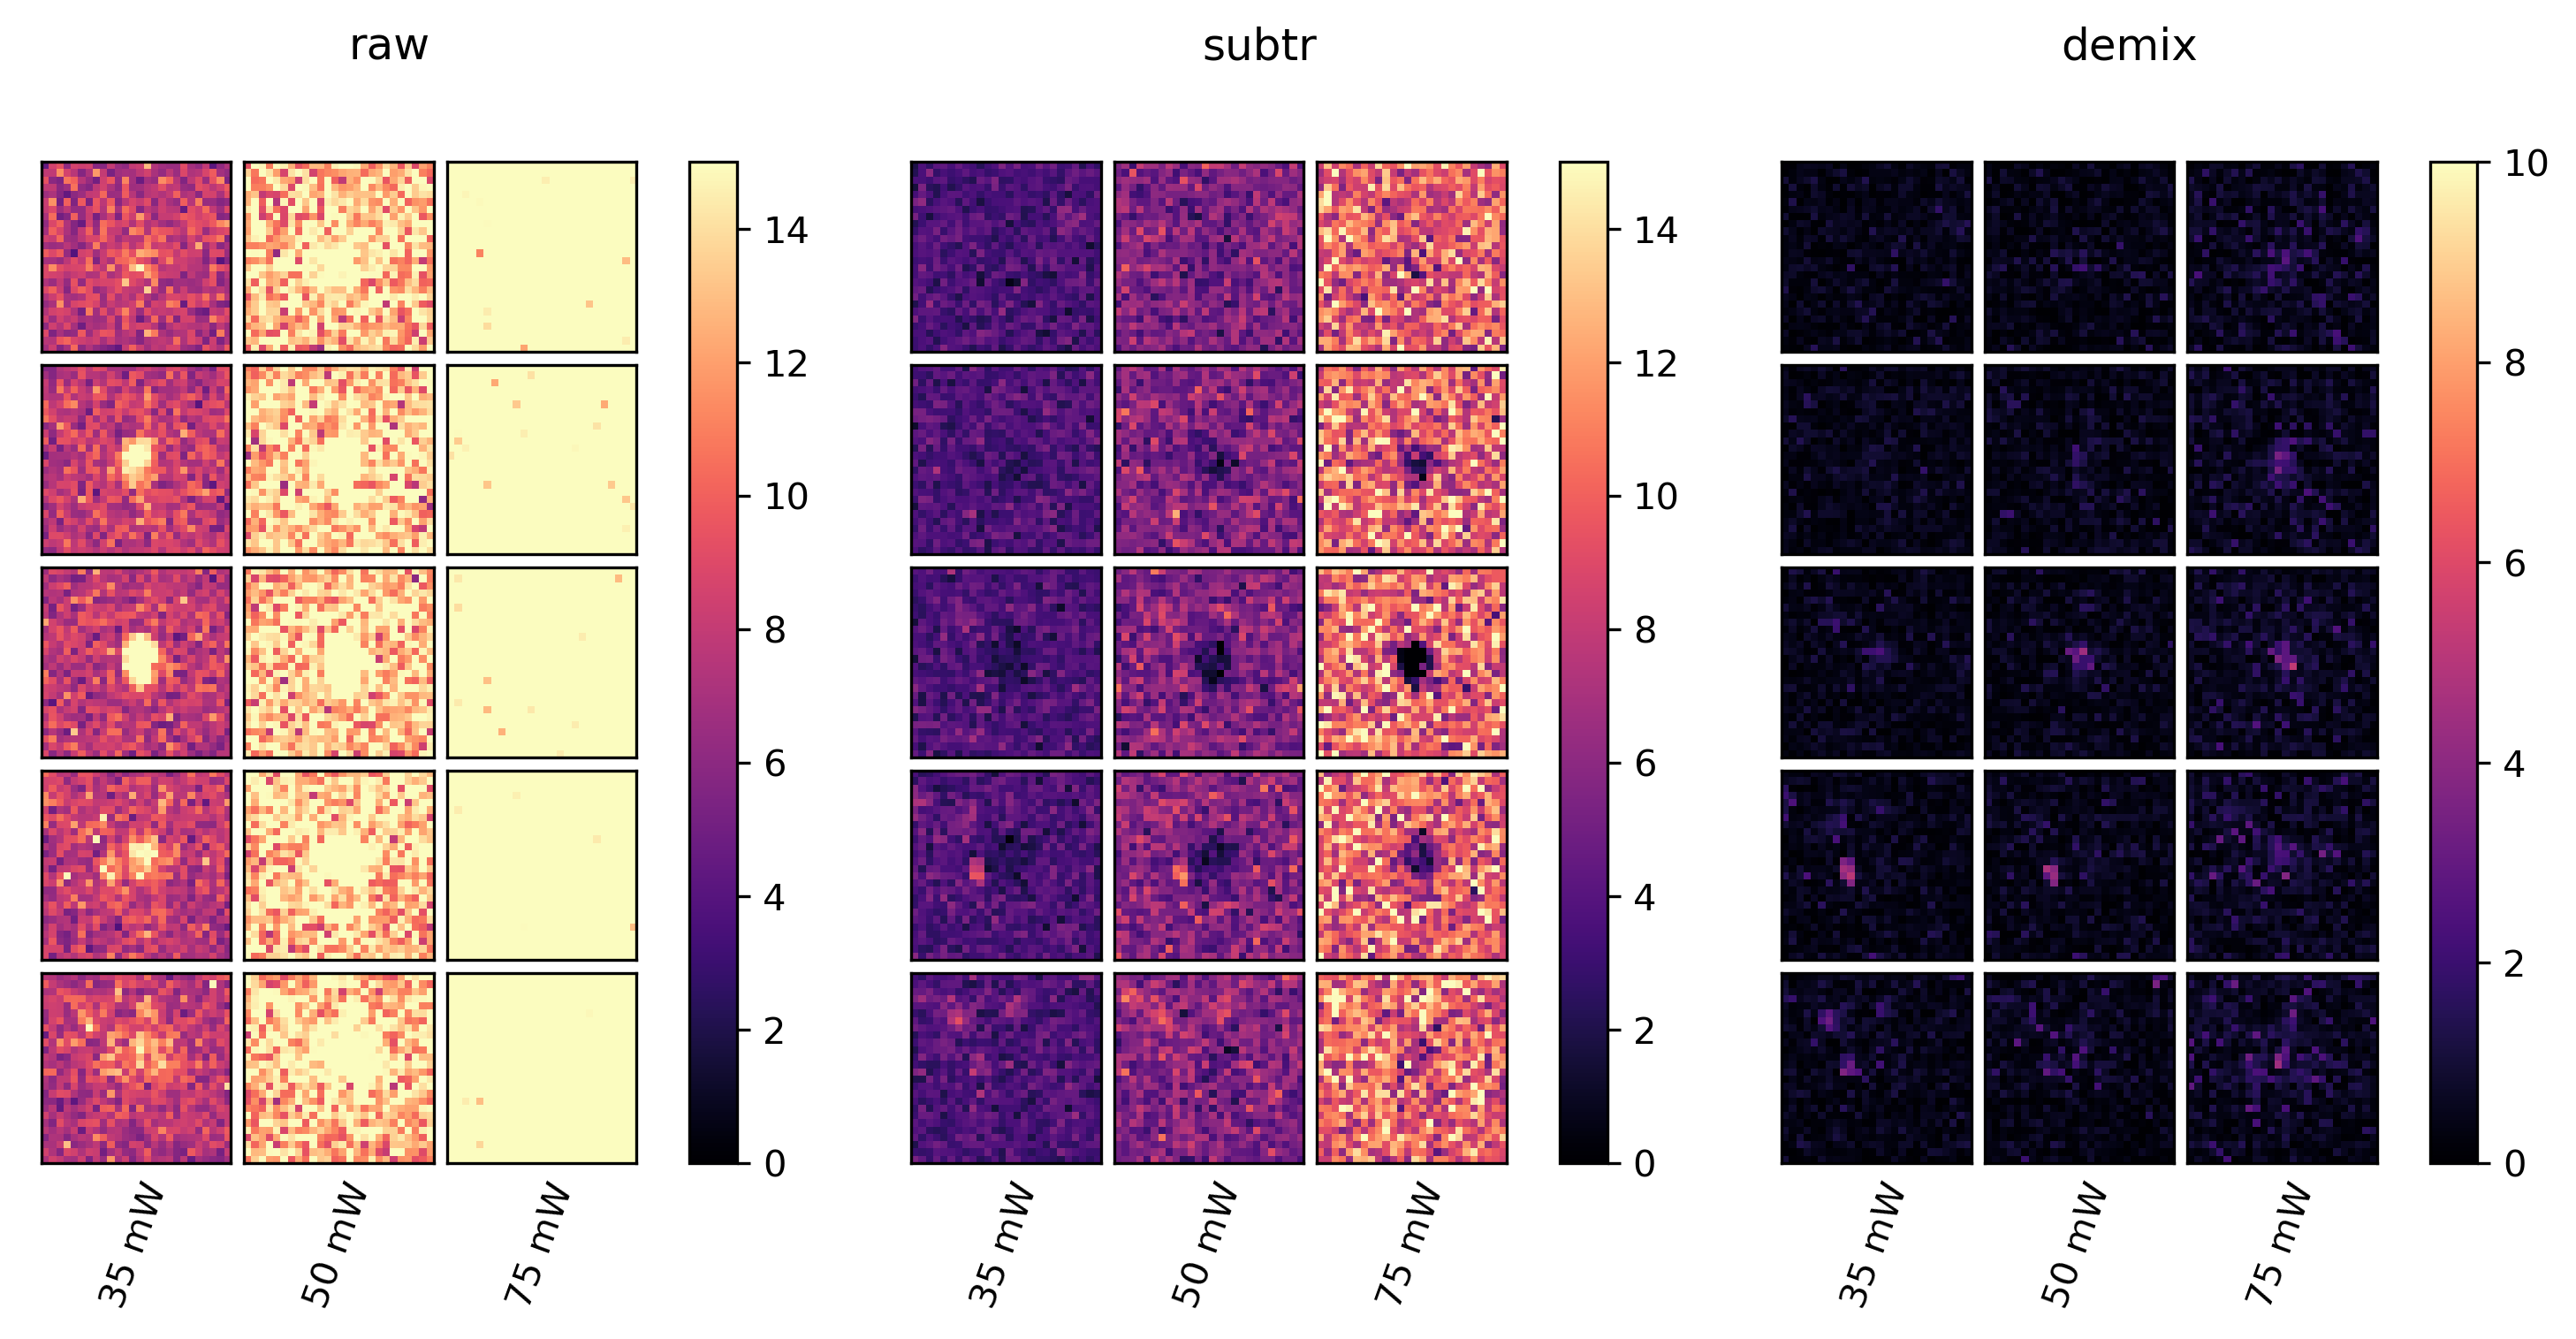

In [11]:
num_planes = results['raw_map'].shape[-1]
fig2 = plt.figure(figsize=(4 * 3, num_planes), dpi=300, facecolor='white')

util.plot_multi_means(fig2,
    [results['raw_map'], results['subtracted_map'], results['demixed_map']], np.arange(num_planes),
#     map_names=['subtracted'],
    cmaps=['magma', 'magma', 'magma'],
    # cbar_labels=['EPSQ (nC)'],
    # zlabels=['subtr', 'demix'],
    map_names=['raw', 'subtr', 'demix'],
    vranges=[(0,15), (0,15), (0,10)],
    powers=np.unique(I))

# plt.savefig(dset_name + '_map_' + '_unconstrained_V_baseline' + '.png', bbox_inches='tight')
plt.show()

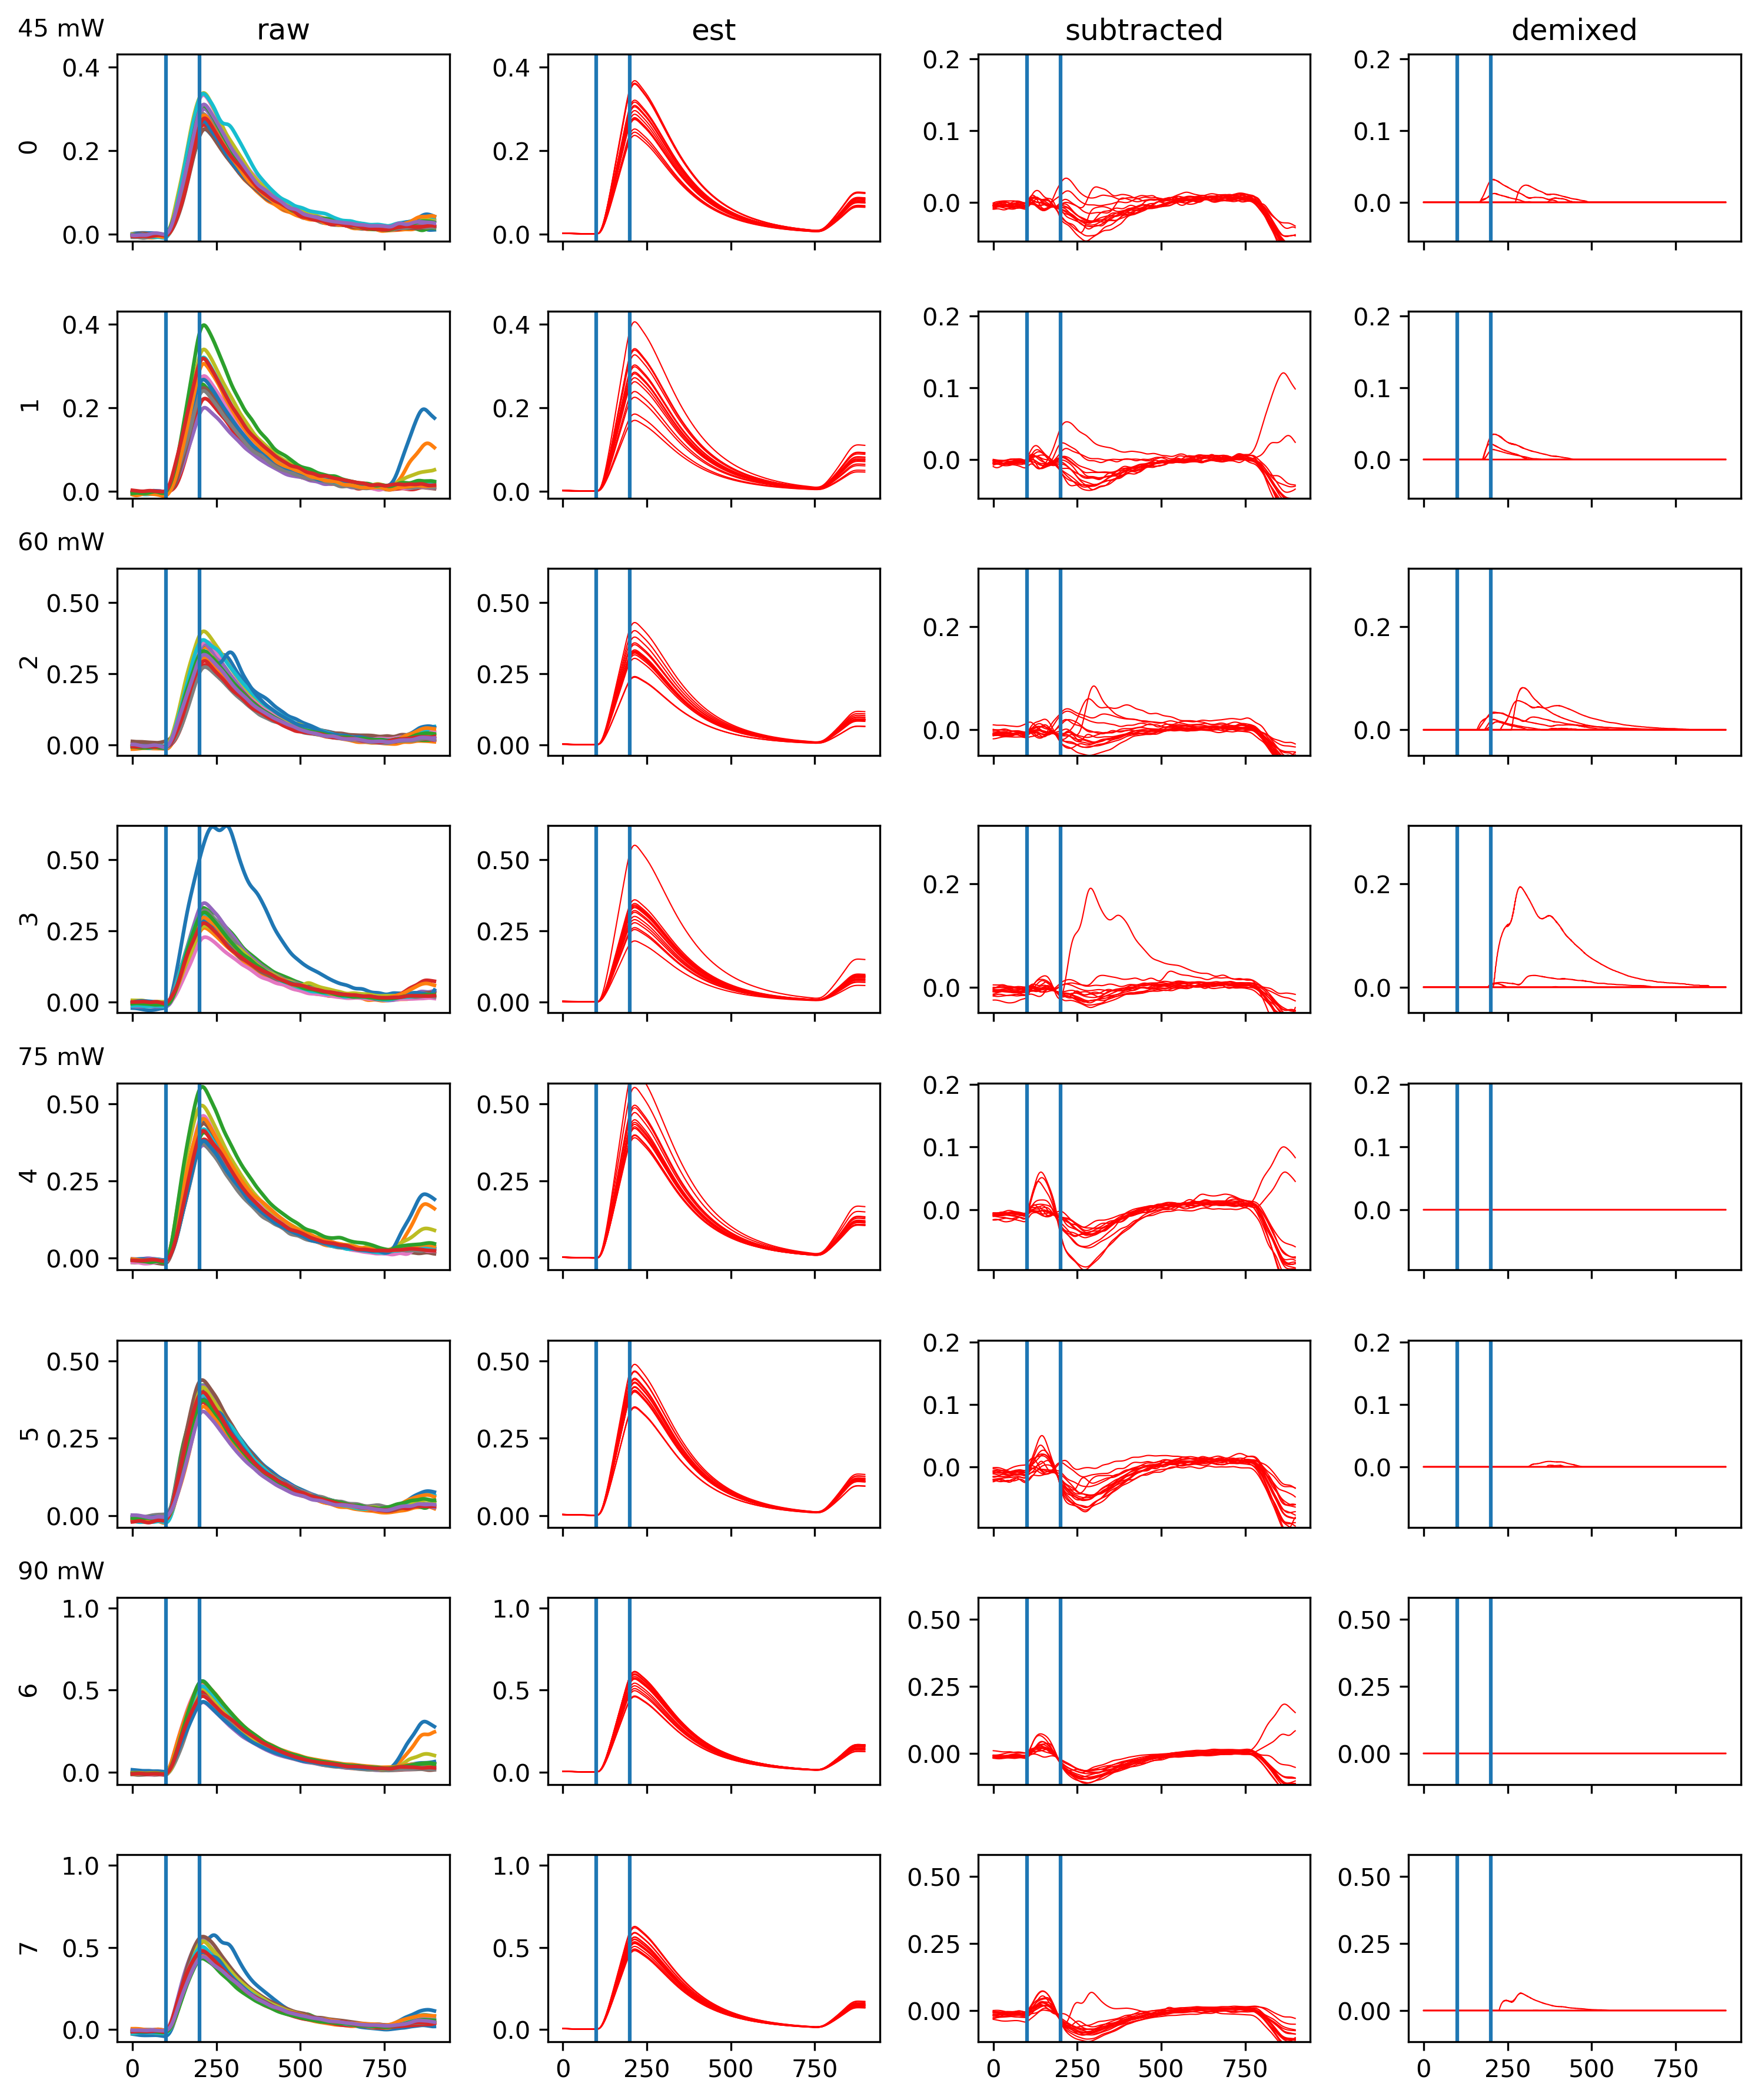

In [7]:

# %matplotlib widget
fig3, axs = subtract_utils.plot_subtraction_comparison(
        results['raw_tensor'],
        [results['est_tensor']],
        [results['subtracted_tensor']],
        [results['demixed_tensor']],
        powers=np.unique(I),
        num_plots_per_power=2,
)
# plt.savefig(dset_name + '_traces_' + '_unconstrained_V_baseline' + '.png', bbox_inches='tight')
plt.show()